In [1]:
# Parameters (Papermill will override these)
city = "seattle"
start_date = "2024-01-01"
end_date = "2024-01-07"
model = "rf"  # or "xgb", "lstm"
k = 3


In [25]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [26]:


# 1. Point to your “dataset” folder
data_dir = 'DATASET'

# 2. Grab every CSV in that directory
csv_paths = glob.glob(os.path.join(data_dir, '*.csv'))

frames = []
for path in csv_paths:
    # 3a. Read each CSV without trying to parse dates up front
    df = pd.read_csv(path, low_memory=False)
    
    # 3b. Convert any timestamp‐like columns if they exist
    for col in ['local_time', 'utc_time', 'date', 'Data Date', 'HourEnding']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # 3c. Tag its origin
    df['source_file'] = os.path.basename(path)
    frames.append(df)

# 4. Concatenate into a single DataFrame
unified = pd.concat(frames, ignore_index=True)

# 5. Review schema
print("Unified shape:", unified.shape)
print("\nColumn dtypes:")
print(unified.dtypes)

# 6. Sample records
print("\nSample 10 rows:")
print(unified.sample(10))


Unified shape: (2598504, 45)

Column dtypes:
company                                                           object
local_time                                                datetime64[ns]
utc_time                                                  datetime64[ns]
demand                                                           float64
city                                                              object
source_file                                                       object
region                                                            object
date                                                      datetime64[ns]
houston                                                          float64
san antonio                                                      float64
dallas                                                           float64
Balancing Authority                                               object
Data Date                                                 datetime64[ns]
Hour N

In [3]:
# 1. Paths
data_dir   = 'DATASET'
demand_csv = os.path.join(data_dir, 'cleaned_balance_data.csv')
weather_files = glob.glob(os.path.join(data_dir, '*.json'))

# 2. Load your demand data
demand_df = pd.read_csv(
    demand_csv,
    parse_dates=['local_time', 'utc_time'], 
    low_memory=False
)
# rename for clarity
demand_df = demand_df.rename(
    columns={
        'local_time': 'timestamp',
        'demand':     'electricity_demand_MWh'
    }
)[['timestamp', 'city', 'electricity_demand_MWh']]

# 3. Load & stack all weather JSONs
weather_frames = []
for path in weather_files:
    city = os.path.splitext(os.path.basename(path))[0]
    w = pd.read_json(path)
    # convert UNIX time → datetime
    w['timestamp'] = pd.to_datetime(w['time'], unit='s')
    # keep & rename only the columns you want
    w = w.rename(
        columns={
            'temperature': 'temperature_F',
            'humidity':    'humidity_pct',
            'windSpeed':   'wind_speed_mph',
            'pressure':    'pressure_mbar',
            'precipIntensity': 'precip_intensity'
        }
    )[
        ['timestamp',
         'temperature_F',
         'humidity_pct',
         'wind_speed_mph',
         'pressure_mbar',
         'precip_intensity']
    ]
    w['city'] = city
    weather_frames.append(w)

weather_df = pd.concat(weather_frames, ignore_index=True)

# 4. Merge demand + weather on timestamp & city
df = pd.merge(
    demand_df,
    weather_df,
    on=['timestamp','city'],
    how='inner'
)

# 5. Review the merged schema & sample
print("Final merged shape:", df.shape)
print("\nColumn dtypes:\n", df.dtypes)
print("\nFirst 10 rows:\n", df.head(10))


Final merged shape: (31888, 8)

Column dtypes:
 timestamp                 datetime64[ns]
city                              object
electricity_demand_MWh           float64
temperature_F                    float64
humidity_pct                     float64
wind_speed_mph                   float64
pressure_mbar                    float64
precip_intensity                 float64
dtype: object

First 10 rows:
             timestamp     city  electricity_demand_MWh  temperature_F  \
0 2018-07-01 07:00:00  phoenix                  2764.0          86.82   
1 2018-07-01 08:00:00  phoenix                  2895.0          83.37   
2 2018-07-01 09:00:00  phoenix                  3096.0          82.22   
3 2018-07-01 10:00:00  phoenix                  3293.0          80.34   
4 2018-07-01 11:00:00  phoenix                  3552.0          79.34   
5 2018-07-01 12:00:00  phoenix                  3821.0          76.67   
6 2018-07-01 13:00:00  phoenix                  4118.0          75.72   
7 2018-07

In [4]:


# 1. Keep only eight core columns
df = df[[
    'timestamp', 'city', 'electricity_demand_MWh',
    'temperature_F', 'humidity_pct',
    'wind_speed_mph', 'pressure_mbar', 'precip_intensity'
]]

# 2. Show missing‐value counts before cleaning
print("Missing before cleaning:\n", df.isna().sum())

# 3. Drop any rows where the target is missing
df = df.dropna(subset=['electricity_demand_MWh'])

# 4.  the weather columns to impute
weather_cols = [
    'temperature_F', 'humidity_pct',
    'wind_speed_mph', 'pressure_mbar', 'precip_intensity'
]

# 5. Impute missing weather values by time‐based interpolation within each city
def impute_city(group):
    g = group.set_index('timestamp').sort_index()
    # interpolate by time
    g[weather_cols] = g[weather_cols].interpolate(method='time')
    # forward/backward fill the edges
    g[weather_cols] = g[weather_cols].ffill().bfill()
    return g.reset_index()

df = df.groupby('city', group_keys=False).apply(impute_city)

# 6.  no more missing values
print("\nMissing after cleaning:\n", df.isna().sum())


Missing before cleaning:
 timestamp                  0
city                       0
electricity_demand_MWh    76
temperature_F              2
humidity_pct               2
wind_speed_mph            10
pressure_mbar             10
precip_intensity          46
dtype: int64

Missing after cleaning:
 timestamp                 0
city                      0
electricity_demand_MWh    0
temperature_F             0
humidity_pct              0
wind_speed_mph            0
pressure_mbar             0
precip_intensity          0
dtype: int64


C:\Users\Dell Inspiron 15\AppData\Local\Temp\ipykernel_1860\2762404780.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('city', group_keys=False).apply(impute_city)


In [5]:
# If datetime column is still called 'local_time', rename :
if 'local_time' in df.columns and 'timestamp' not in df.columns:
    df = df.rename(columns={'local_time':'timestamp'})

# 1. Extract time‐based features
df['hour']        = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek    # Monday=0…Sunday=6
df['month']       = df['timestamp'].dt.month

# Map month → season
def month_to_season(m):
    if m in (12,1,2):   return 'winter'
    if m in (3,4,5):    return 'spring'
    if m in (6,7,8):    return 'summer'
    return 'fall'

df['season'] = df['month'].apply(month_to_season)

# 2. Scale continuous variables
cont_vars = [
    'electricity_demand_MWh',
    'temperature_F',
    'humidity_pct',
    'wind_speed_mph',
    'pressure_mbar',
    'precip_intensity'
]

scaler = StandardScaler()
df[cont_vars] = scaler.fit_transform(df[cont_vars])

# 3.  check
print(df[['timestamp','city','hour','day_of_week','month','season']].head())
print("\nScaled sample of continuous cols:")
print(df[cont_vars].head())


            timestamp     city  hour  day_of_week  month  season
0 2018-07-01 07:00:00  phoenix     7            6      7  summer
1 2018-07-01 08:00:00  phoenix     8            6      7  summer
2 2018-07-01 09:00:00  phoenix     9            6      7  summer
3 2018-07-01 10:00:00  phoenix    10            6      7  summer
4 2018-07-01 11:00:00  phoenix    11            6      7  summer

Scaled sample of continuous cols:
   electricity_demand_MWh  temperature_F  humidity_pct  wind_speed_mph  \
0                0.365486       1.376558     -1.515866       -0.055322   
1                0.454493       1.184175     -1.403941       -0.188516   
2                0.591060       1.120047     -1.441250       -0.867804   
3                0.724911       1.015212     -1.403941       -0.641374   
4                0.900886       0.959449     -1.441250       -0.747929   

   pressure_mbar  precip_intensity  
0      -1.041318         -0.281875  
1      -0.978302         -0.281875  
2      -0.946793   

In [6]:
# 1.  the continuous variables to summarize
cont_vars = [
    'electricity_demand_MWh',
    'temperature_F',
    'humidity_pct',
    'wind_speed_mph',
    'pressure_mbar',
    'precip_intensity'
]

# 2. date and week_start columns
df['date']       = df['timestamp'].dt.date
df['week_start'] = df['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

# 3. Daily summary: mean, std, min, max
daily_stats = (
    df
    .groupby(['city','date'])[cont_vars]
    .agg(['mean','std','min','max'])
)
# flatten the MultiIndex in columns
daily_stats.columns = ['_'.join(col) for col in daily_stats.columns]
daily_stats = daily_stats.reset_index()

# 4. Weekly summary: mean, std, min, max
weekly_stats = (
    df
    .groupby(['city','week_start'])[cont_vars]
    .agg(['mean','std','min','max'])
)
weekly_stats.columns = ['_'.join(col) for col in weekly_stats.columns]
weekly_stats = weekly_stats.reset_index()

# 5. Inspect
print("Daily summary (first 10 rows):")
print(daily_stats.head(10))

print("\nWeekly summary (first 10 rows):")
print(weekly_stats.head(10))


Daily summary (first 10 rows):
      city        date  electricity_demand_MWh_mean  \
0  phoenix  2018-07-01                     1.401675   
1  phoenix  2018-07-02                     1.388896   
2  phoenix  2018-07-03                     1.508648   
3  phoenix  2018-07-04                     1.512696   
4  phoenix  2018-07-05                     1.888909   
5  phoenix  2018-07-06                     2.106189   
6  phoenix  2018-07-07                     2.073179   
7  phoenix  2018-07-08                     2.013926   
8  phoenix  2018-07-09                     1.580131   
9  phoenix  2018-07-10                     1.203380   

   electricity_demand_MWh_std  electricity_demand_MWh_min  \
0                    0.626115                    0.365486   
1                    0.728673                    0.474196   
2                    0.685951                    0.611444   
3                    0.645776                    0.663761   
4                    0.898996                    0.749371 

In [7]:
# 4. Weekly aggregation and print

#  the continuous variables (same as for daily)
cont_vars = [
    'electricity_demand_MWh',
    'temperature_F',
    'humidity_pct',
    'wind_speed_mph',
    'pressure_mbar',
    'precip_intensity'
]

# Ensure 'week_start' exists
if 'week_start' not in df.columns:
    df['week_start'] = df['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

# Compute weekly summary: mean, std, min, max
weekly_stats = (
    df
    .groupby(['city','week_start'])[cont_vars]
    .agg(['mean','std','min','max'])
)

# Flatten the MultiIndex columns
weekly_stats.columns = ['_'.join(col) for col in weekly_stats.columns]
weekly_stats = weekly_stats.reset_index()

# Print the first 10 rows of the weekly summary
print("Weekly Summary (first 10 rows):")
print(weekly_stats.head(10))


Weekly Summary (first 10 rows):
      city week_start  electricity_demand_MWh_mean  \
0  phoenix 2018-06-25                     1.401675   
1  phoenix 2018-07-02                     1.784635   
2  phoenix 2018-07-09                     1.422362   
3  phoenix 2018-07-16                     1.748564   
4  phoenix 2018-07-23                     2.076293   
5  phoenix 2018-07-30                     1.961205   
6  phoenix 2018-08-06                     1.757869   
7  phoenix 2018-08-13                     1.652839   
8  phoenix 2018-08-20                     1.634627   
9  phoenix 2018-08-27                     1.478420   

   electricity_demand_MWh_std  electricity_demand_MWh_min  \
0                    0.626115                    0.365486   
1                    0.748763                    0.474196   
2                    0.475815                    0.591740   
3                    0.588340                    0.678029   
4                    0.716818                    0.947768   
5      

In [8]:


# 5. Anomaly & Error Detection

# 5a. Define continuous features
cont_vars = [
    'electricity_demand_MWh',
    'temperature_F',
    'humidity_pct',
    'wind_speed_mph',
    'pressure_mbar',
    'precip_intensity'
]

# 5b. Z-score method
z_scores = (df[cont_vars] - df[cont_vars].mean()) / df[cont_vars].std()
df['anomaly_zscore'] = (z_scores.abs() > 3).any(axis=1)

# 5c. IQR method
Q1 = df[cont_vars].quantile(0.25)
Q3 = df[cont_vars].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['anomaly_iqr'] = ((df[cont_vars] < lower_bound) | (df[cont_vars] > upper_bound)).any(axis=1)

# 5d. Isolation Forest
iso = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)
iso.fit(df[cont_vars])
df['anomaly_iso'] = iso.predict(df[cont_vars]) == -1

# 5e. Consolidate anomaly flags
df['anomaly_flag'] = df[['anomaly_zscore','anomaly_iqr','anomaly_iso']].any(axis=1)

# 5f. Summary counts
print("Anomaly counts:")
print(" - Z-score anomalies:    ", df['anomaly_zscore'].sum())
print(" - IQR anomalies:        ", df['anomaly_iqr'].sum())
print(" - IsolationForest:      ", df['anomaly_iso'].sum())
print(" - Total flagged:        ", df['anomaly_flag'].sum())

# 5g. Inspect flagged records
print("\nSample anomalies:")
print(df[df['anomaly_flag']].head(10))


Anomaly counts:
 - Z-score anomalies:     1283
 - IQR anomalies:         5566
 - IsolationForest:       319
 - Total flagged:         5567

Sample anomalies:
              timestamp     city  electricity_demand_MWh  temperature_F  \
59  2018-07-03 18:00:00  phoenix                2.522036       1.963189   
103 2018-07-05 14:00:00  phoenix                2.703447       1.404440   
104 2018-07-05 15:00:00  phoenix                2.941931       1.670989   
105 2018-07-05 16:00:00  phoenix                3.047924       1.899061   
106 2018-07-05 17:00:00  phoenix                3.181775       2.075273   
107 2018-07-05 18:00:00  phoenix                3.149841       2.293865   
108 2018-07-05 19:00:00  phoenix                2.996966       2.455021   
109 2018-07-05 20:00:00  phoenix                2.771391       2.574355   
110 2018-07-05 21:00:00  phoenix                2.659963       2.644617   
112 2018-07-05 23:00:00  phoenix                2.081757       2.753355   

     humidity_pc

In [9]:
# Continuous variables to check
cont_vars = [
    'electricity_demand_MWh',
    'temperature_F',
    'humidity_pct',
    'wind_speed_mph',
    'pressure_mbar',
    'precip_intensity'
]

# 1. Fit IsolationForest on complete (non-NaN) rows
complete_idx = df.dropna(subset=cont_vars).index
X_complete  = df.loc[complete_idx, cont_vars]

iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso.fit(X_complete)

# 2. Flag anomalies
pred = iso.predict(X_complete) == -1
df['anomaly_iso'] = False
df.loc[complete_idx, 'anomaly_iso'] = pred

# 3. Winsorize extremes at the 1st and 99th percentiles
for col in cont_vars:
    low, high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower=low, upper=high)

# 4. Drop IsolationForest-detected anomalies
df_clean = df[~df['anomaly_iso']].reset_index(drop=True)

# 5. Cleanup
df_clean = df_clean.drop(columns=['anomaly_iso'], errors='ignore')


orig_len  = len(df)
iso_count = df['anomaly_iso'].sum()
print(f"Original rows:             {orig_len}")
print(f"IsolationForest anomalies: {iso_count}")
print(f"Cleaned rows:              {len(df_clean)}")
print(f"Rows removed:              {orig_len - len(df_clean)}")


Original rows:             31812
IsolationForest anomalies: 318
Cleaned rows:              31494
Rows removed:              318


# Clustering Task

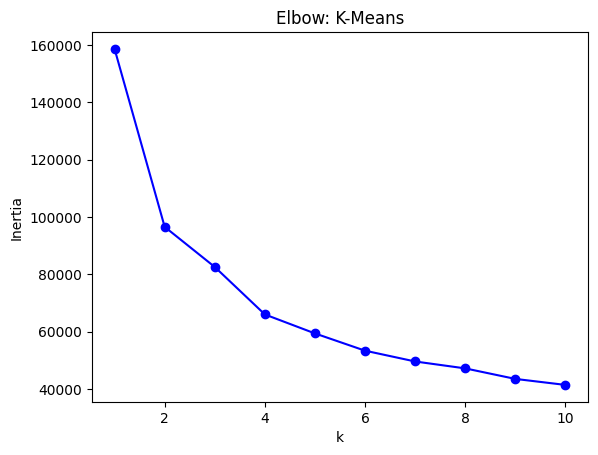

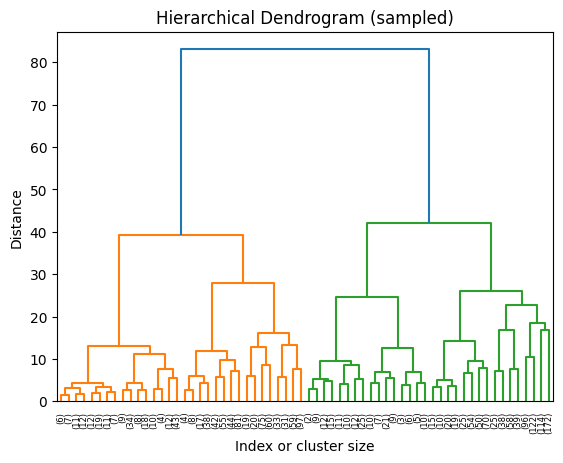

Silhouette K-Means k=4: 0.27
K-Means ARI stability: [0.992 0.99  0.992 0.988 0.991 0.989 0.995 0.995 0.995 0.995] Mean: 0.992

Cluster Profiles:
             avg_demand  avg_temp   avg_hour
cluster_km                                 
0.0           1.371216  1.580758  12.084685
1.0          -0.605392 -0.689091  11.310691
2.0           0.175485  0.112561  11.253747
3.0          -0.698497 -0.590566  11.723584
Cluster 0.0: high-demand hot around hour 12
Cluster 1.0: low-demand cool around hour 11
Cluster 2.0: high-demand hot around hour 11
Cluster 3.0: low-demand cool around hour 12


In [10]:
# 1. Dimensionality Reduction: PCA + t-SNE

features = [
    'electricity_demand_MWh','temperature_F','humidity_pct',
    'wind_speed_mph','pressure_mbar','precip_intensity'
]
mask = df_clean[features].notna().all(axis=1)
X = df_clean.loc[mask, features].values

# 1a. PCA → 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
df_clean.loc[mask, ['pca_1','pca_2']] = X_pca

# 1b. t-SNE → 2 dims (on a 2k‐sample for speed)
sample = df_clean.loc[mask].sample(n=2000, random_state=42)
X_s = sample[features].values
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
X_tsne = tsne.fit_transform(X_s)
sample[['tsne_1','tsne_2']] = X_tsne

# 2. Clustering Algorithms

# 2a. K-Means: Elbow method
inertia = []
Ks = range(1, 11)
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    inertia.append(km.inertia_)
plt.plot(Ks, inertia, 'bo-')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow: K-Means')
plt.show()

# 2b. DBSCAN on PCA space
db = DBSCAN(eps=0.3, min_samples=5).fit(X_pca)
df_clean.loc[mask, 'dbscan_label'] = db.labels_

# 2c. Hierarchical clustering: dendrogram (on sample)
Z = linkage(X_s, method='ward')
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Dendrogram (sampled)')
plt.xlabel('Index or cluster size'); plt.ylabel('Distance')
plt.show()

# 3. Evaluation

# 3a. Silhouette for K-Means (pick k from elbow, say k=4)
k = 4
labels_km = KMeans(n_clusters=k, random_state=42).fit_predict(X)
print("Silhouette K-Means k=4:", round(silhouette_score(X, labels_km), 3))

# 3b. Silhouette for DBSCAN (ignore noise = -1)
labels_db = db.labels_
core = labels_db != -1
if len(set(labels_db[core])) > 1:
    print("Silhouette DBSCAN:", round(silhouette_score(X_pca[core], labels_db[core]), 3))

# 3c. Cluster stability for K-Means via ARI
aris = []
n = X.shape[0]
for _ in range(10):
    idx = np.random.choice(n, int(0.8*n), replace=False)
    l_ref  = labels_km[idx]
    l_boot = KMeans(n_clusters=k, random_state=42).fit_predict(X[idx])
    aris.append(adjusted_rand_score(l_ref, l_boot))
print("K-Means ARI stability:", np.round(aris,3), "Mean:", round(np.mean(aris),3))

# 4. Interpretation: Characterize clusters

# 4a. Assign final K-Means labels to df_clean
df_clean.loc[mask, 'cluster_km'] = labels_km

# 4b. Compute mean profiles per cluster
profile = (
    df_clean
    .groupby('cluster_km')[
        ['electricity_demand_MWh','temperature_F','hour']
    ]
    .mean()
    .rename(columns={
        'electricity_demand_MWh':'avg_demand',
        'temperature_F':'avg_temp',
        'hour':'avg_hour'
    })
)
print("\nCluster Profiles:\n", profile)

# 4c. Describe clusters
# e.g., for each cluster index, print a short text based on avg_demand/temp/hour
for cid, row in profile.iterrows():
    desc = f"Cluster {cid}: "
    desc += "high-demand " if row.avg_demand>0 else "low-demand "
    desc += "hot "        if row.avg_temp>0   else "cool "
    desc += f"around hour {round(row.avg_hour)}"
    print(desc)


# 4.Predictive Modelling

In [12]:

df_clean = df.copy()

# Step 1: a copy for processing
df_pm = df_clean.copy()

# Step 2:  lag features
df_pm['lag_1h'] = df_pm.groupby('city')['electricity_demand_MWh'].shift(1)
df_pm['lag_24h'] = df_pm.groupby('city')['electricity_demand_MWh'].shift(24)

# Step 3:  target variable (24 hours ahead)
df_pm['target'] = df_pm.groupby('city')['electricity_demand_MWh'].shift(-24)

# Step 4: Drop rows with missing values in lag/target
df_pm = df_pm.dropna(subset=['lag_1h', 'lag_24h', 'target'])

# Step 5: Define features
features = ['lag_1h', 'lag_24h', 'temperature_F', 'humidity_pct',
            'wind_speed_mph', 'pressure_mbar', 'precip_intensity']

if 'cluster_km' in df_pm.columns:
    features.append('cluster_km')

X = df_pm[features]
y = df_pm['target']


In [13]:

df_pm = df_clean.copy()

# Create lag features
df_pm['lag_1h'] = df_pm.groupby('city')['electricity_demand_MWh'].shift(1)
df_pm['lag_24h'] = df_pm.groupby('city')['electricity_demand_MWh'].shift(24)

#  target variable (24 hours ahead)
df_pm['target'] = df_pm.groupby('city')['electricity_demand_MWh'].shift(-24)

# Drop rows with NaN values
df_pm = df_pm.dropna(subset=['lag_1h', 'lag_24h', 'target'])

#  features
features = ['lag_1h', 'lag_24h', 'temperature_F', 'humidity_pct',
            'wind_speed_mph', 'pressure_mbar', 'precip_intensity']
if 'cluster_km' in df_pm.columns:
    features.append('cluster_km')

X = df_pm[features]
y = df_pm['target']


In [14]:
# Time-based train-test split
split_date = pd.to_datetime('2020-01-01')
train_mask = df_pm['timestamp'] < split_date
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]


In [15]:
# Baseline model: previous day's same hour
baseline = df_pm.groupby('city')['electricity_demand_MWh'].shift(24)
baseline = baseline[~train_mask]
mask_b = baseline.notna()
y_b_true = y_test[mask_b]
y_b_pred = baseline[mask_b]

print("Baseline metrics:")
print(" MAE:  ", mean_absolute_error(y_b_true, y_b_pred))
print(" RMSE: ", mean_squared_error(y_b_true, y_b_pred, squared=False))
print(" MAPE: ", mean_absolute_percentage_error(y_b_true, y_b_pred))


Baseline metrics:
 MAE:   0.08714451799293321
 RMSE:  0.13108303316877218
 MAPE:  0.9836857205478386


C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
y_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
y_rf = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
y_xgb = xgb.predict(X_test)

# Stacking Ensemble
stack = StackingRegressor(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=LinearRegression()
).fit(X_train, y_train)
y_stack = stack.predict(X_test)


In [17]:
# Evaluation function
def print_metrics(name, y_true, y_pred):
    print(f"\n{name}:")
    print(" MAE:  ", mean_absolute_error(y_true, y_pred))
    print(" RMSE: ", mean_squared_error(y_true, y_pred, squared=False))
    print(" MAPE: ", mean_absolute_percentage_error(y_true, y_pred))


In [18]:
# Print metrics
print_metrics("Linear Regression", y_test, y_lr)
print_metrics("Random Forest", y_test, y_rf)
print_metrics("XGBoost", y_test, y_xgb)
print_metrics("Stacking Ensemble", y_test, y_stack)



Linear Regression:
 MAE:   0.07846448389879765
 RMSE:  0.11422396845937394
 MAPE:  1.4371954841189958

Random Forest:
 MAE:   0.08107845986281631
 RMSE:  0.11708705239537455
 MAPE:  2.5226562855456693

XGBoost:
 MAE:   0.07956127661758515
 RMSE:  0.11547495034901128
 MAPE:  2.3573934540093555

Stacking Ensemble:
 MAE:   0.08009988684143726
 RMSE:  0.11538210217258124
 MAPE:  2.4953434540671324


C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, 

In [19]:
# Hyperparameter tuning for Random Forest
tscv = TimeSeriesSplit(n_splits=5)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
}
grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1
)
grid_rf.fit(X, y)
print("RF best params:", grid_rf.best_params_)


RF best params: {'max_depth': 10, 'n_estimators': 200}


In [20]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42, verbosity=0),
    param_grid=param_grid_xgb,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1
)
grid_xgb.fit(X, y)
print("XGB best params:", grid_xgb.best_params_)


XGB best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [21]:
#  data for LSTM
df_pm_lstm = df_pm.dropna(subset=features + ['target'])

# Convert data to float32 to reduce memory usage
df_pm_lstm[features] = df_pm_lstm[features].astype(np.float32)

n_input = 24
X_seq, y_seq = [], []

# Instead of storing all sequences in memory at once, create them in a memory-efficient way
for i in range(len(df_pm_lstm) - n_input):
    X_seq.append(df_pm_lstm[features].iloc[i:i + n_input].values)
    y_seq.append(df_pm_lstm['target'].iloc[i + n_input])

# Convert lists to numpy arrays, which are more memory efficient
X_seq = np.array(X_seq, dtype=np.float32)  # Ensure using float32
y_seq = np.array(y_seq, dtype=np.float32)  # Ensure using float32

# Split into training and testing sets
split = int(0.8 * len(X_seq))
X_tr, X_te = X_seq[:split], X_seq[split:]
y_tr, y_te = y_seq[:split], y_seq[split:]

# Model definition (LSTM with reduced units for memory efficiency)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, activation='relu', input_shape=(n_input, len(features))),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_tr, y_tr, validation_data=(X_te, y_te), epochs=10, batch_size=64)


Epoch 1/10


C:\Program Files\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


397/397 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1912 - val_loss: 0.0111
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0354 - val_loss: 0.0088
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0278 - val_loss: 0.0079
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0260 - val_loss: 0.0077
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0244 - val_loss: 0.0079
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0232 - val_loss: 0.0071
Epoch 7/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0247 - val_loss: 0.0069
Epoch 8/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0232 - val_loss: 0.0066
Epoch 9/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0216 - val_loss: 0.0066
Epoch 10/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0224 - val_loss: 0.0088


In [22]:
# LSTM model
model = Sequential([
    LSTM(64, input_shape=(n_input, len(features))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')

# Fit model with early stopping
es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(
    X_tr, y_tr,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)


Epoch 1/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2087 - val_loss: 0.0843
Epoch 2/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1221 - val_loss: 0.0558
Epoch 3/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1143 - val_loss: 0.0569
Epoch 4/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1073 - val_loss: 0.0535
Epoch 5/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1056 - val_loss: 0.0486
Epoch 6/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1037 - val_loss: 0.0682
Epoch 7/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0989 - val_loss: 0.0478
Epoch 8/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0984 - val_loss: 0.0481
Epoch 9/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0973 - val_loss: 0.0489
Epoch 10/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0958 - val_loss: 0.0488
Epoch 11/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0934 - val_loss: 0.0506
Epoch 12/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

In [23]:
# Evaluate LSTM model
y_pred_lstm = model.predict(X_te).ravel()
print("LSTM MAE:", mean_absolute_error(y_te, y_pred_lstm))


199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM MAE: 0.051080707
